In [22]:
import pandas as pd
import seaborn as sns
from pydataset import data
import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings('ignore')


Let's load a dataset and take a look at it.

In [23]:
NAME='AirPassengers' # AirPassengers, nottem, nhtemp
df = data(NAME)
df[:5]

,time,AirPassengers
1,1949.000000,112
2,1949.083333,118
3,1949.166667,132
4,1949.250000,129
5,1949.333333,121


Let's look at the decompostion of the series

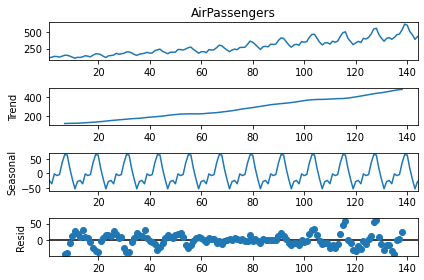

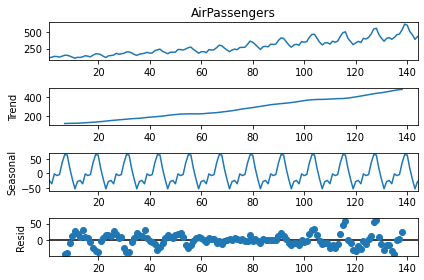

In [26]:
result = seasonal_decompose(df['AirPassengers'], model='additive', period=12)
result.plot()

Now we can plot it, and look also at the Sliding Mean and Sliding STD.

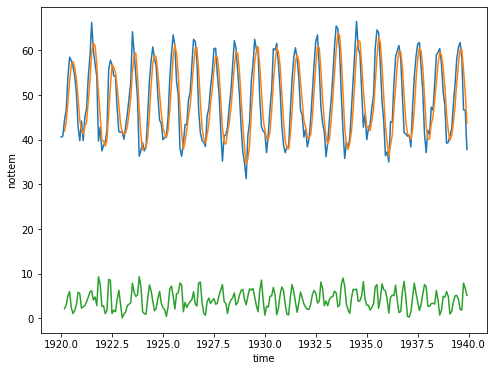

In [18]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df,x='time',y=NAME)

rolling_mean = df[NAME].rolling(window = 3).mean()
plt.plot(df['time'],rolling_mean)

rolling_std = df.rolling(window = 3).std()
plt.plot(df['time'],rolling_std[NAME])

We may also observe, when dividing the data into yearly bins, about trends.

(31.3, 66.5)

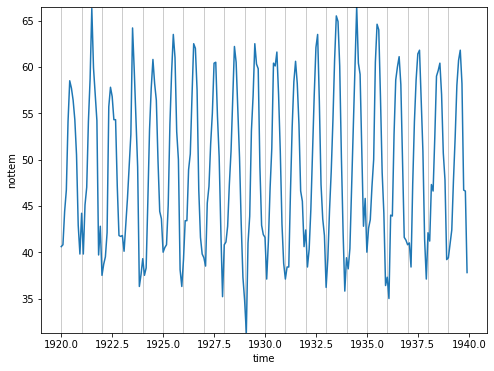

In [19]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df,x='time',y=NAME)
x = list(range(int(min(df['time'])),int(max(df['time'])+1)))
for _ in x:
    sns.lineplot(x=_,y=[min(df[NAME]),max(df[NAME])],lw=1,color='black')
plt.ylim(min(df[NAME]),max(df[NAME]))

Let's have a look at the autocorrelation of the time series.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

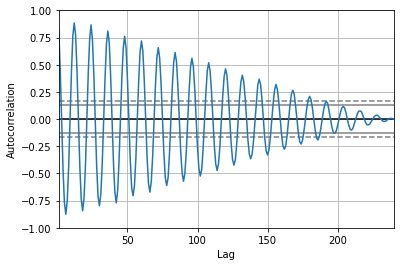

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df[NAME])

Now we run the ARIMA model

/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

                               SARIMAX Results                                
Dep. Variable:                 nottem   No. Observations:                  240
Model:                ARIMA(13, 1, 5)   Log Likelihood                -562.750
Date:                Thu, 28 Oct 2021   AIC                           1163.500
Time:                        11:30:35   BIC                           1229.553
Sample:                             0   HQIC                          1190.117
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1541      0.310      0.498      0.619      -0.453       0.761
ar.L2         -0.2815      0.340     -0.829      0.407      -0.947       0.384
ar.L3          0.1537      0.304      0.505      0.6

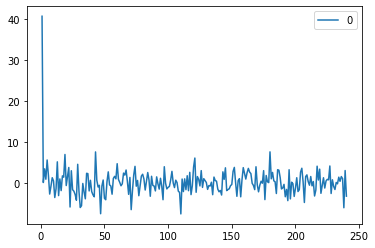

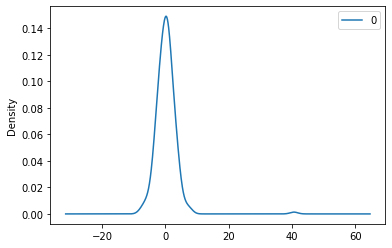

                0
count  240.000000
mean     0.260717
std      3.644303
min     -7.430240
25%     -1.543951
50%      0.209169
75%      1.646156
max     40.600000


In [11]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df[NAME], order=(13,1,5))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [12]:
Y = df[NAME].values
split = int(len(Y) * 0.6)
_train = Y[:split]
test = Y[split:]
train = [x for x in _train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(train, order=(5,1,0))
	model_fit = model.fit()
	out = model_fit.forecast()
	predictions.append(out[0])
	obs = test[t]
	train.append(obs)
	print(f'TEST = {out[0]} - PRED = {obs}')
rmse = math.sqrt(mean_squared_error(df[NAME][split:], predictions))
print(f"RMSE: {rmse}")


TEST = 41.402849705765846 - PRED = 42.4
TEST = 44.98677542387956 - PRED = 38.4
TEST = 40.89356649638103 - PRED = 40.3
TEST = 41.306277512606215 - PRED = 44.6
TEST = 46.86183525973239 - PRED = 50.9
TEST = 53.783006866324 - PRED = 57.0
TEST = 60.710496199414074 - PRED = 62.1
TEST = 62.96572374611724 - PRED = 63.5
TEST = 62.029719617614546 - PRED = 56.3
TEST = 51.525489220204534 - PRED = 47.3
TEST = 40.013012865863786 - PRED = 43.6
TEST = 38.266897727020336 - PRED = 41.8
TEST = 42.104107689894114 - PRED = 36.2
TEST = 39.627626525571486 - PRED = 39.3
TEST = 42.48980107638742 - PRED = 44.5
TEST = 47.956646950258744 - PRED = 48.7
TEST = 53.084995284755905 - PRED = 54.2
TEST = 57.47109693793512 - PRED = 60.8
TEST = 61.02633422821365 - PRED = 65.5
TEST = 65.30850179182957 - PRED = 64.9
TEST = 63.16106595795786 - PRED = 60.1
TEST = 55.31700087394553 - PRED = 50.2
TEST = 43.28190046145178 - PRED = 42.1
TEST = 36.31392978859269 - PRED = 35.8
TEST = 33.82703601243013 - PRED = 39.4
TEST = 42.990693

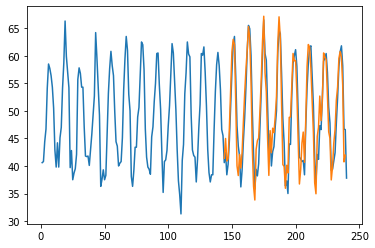

In [13]:
plt.plot(df[NAME])
plt.plot(range(split,len(Y)),predictions)

In [14]:
Y = df[NAME].values
split = int(len(Y) * 0.8)
_train = Y[:split]

df_result = pd.DataFrame()

for p in [0,1,2,3,4]:
    for d in [0,1,2]:
        for q in [0,1,2]:
            test = Y[split:len(Y)]
            train = [x for x in _train] 
            predictions = list()
            for t in range(len(test)):
                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit()
                out = model_fit.forecast()
                predictions.append(out[0])
                obs = test[t]
                train.append(obs)
            rmse = math.sqrt(mean_squared_error(df[NAME][split:], predictions))
            df_result = df_result.append({'p':int(p),'d':int(d),'q':int(q),'rmse':rmse}, ignore_index=True)
            print(f"ARIMA({p},{d},{q}) - RMSE = {rmse}")

ARIMA(0,0,0) - RMSE = 8.367438341661787
ARIMA(0,0,1) - RMSE = 5.757085465480193
ARIMA(0,0,2) - RMSE = 4.711831757294677
ARIMA(0,1,0) - RMSE = 5.143604443060009
ARIMA(0,1,1) - RMSE = 4.910403814962208
ARIMA(0,1,2) - RMSE = 4.42656471066216
ARIMA(0,2,0) - RMSE = 5.616271004859552
ARIMA(0,2,1) - RMSE = 5.195540033232998
ARIMA(0,2,2) - RMSE = 5.0035860714320854
ARIMA(1,0,0) - RMSE = 4.903018155210208
ARIMA(1,0,1) - RMSE = 4.600790666623443
ARIMA(1,0,2) - RMSE = 4.050862557582439
ARIMA(1,1,0) - RMSE = 4.730755171579027
ARIMA(1,1,1) - RMSE = 4.697935879455545
ARIMA(1,1,2) - RMSE = 4.602198444925993
ARIMA(1,2,0) - RMSE = 5.058162907882221
ARIMA(1,2,1) - RMSE = 5.046499890762119
ARIMA(1,2,2) - RMSE = 4.9973025213710836
ARIMA(2,0,0) - RMSE = 4.12794482387115
ARIMA(2,0,1) - RMSE = 3.021969760418706


/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo

ARIMA(2,0,2) - RMSE = 2.348923684191647
ARIMA(2,1,0) - RMSE = 4.646088438554586
ARIMA(2,1,1) - RMSE = 4.585483860976889
ARIMA(2,1,2) - RMSE = 3.0546280885829167
ARIMA(2,2,0) - RMSE = 5.0418673310310655
ARIMA(2,2,1) - RMSE = 4.822103637829895
ARIMA(2,2,2) - RMSE = 5.043547143075676
ARIMA(3,0,0) - RMSE = 3.2022196869789963
ARIMA(3,0,1) - RMSE = 2.696874754554431


/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo

ARIMA(3,0,2) - RMSE = 2.3115558416214896
ARIMA(3,1,0) - RMSE = 4.379353642728335
ARIMA(3,1,1) - RMSE = 3.2032550453856388
ARIMA(3,1,2) - RMSE = 2.7511893249436037
ARIMA(3,2,0) - RMSE = 5.033207723971925
ARIMA(3,2,1) - RMSE = 9.843375824454172


/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo

ARIMA(3,2,2) - RMSE = 4.872882553642232
ARIMA(4,0,0) - RMSE = 2.9575117751667013
ARIMA(4,0,1) - RMSE = 2.6823521277019156
ARIMA(4,0,2) - RMSE = 2.668289095306574
ARIMA(4,1,0) - RMSE = 3.9834971337348333


/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo

ARIMA(4,1,1) - RMSE = 2.9610945108994424


/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo

ARIMA(4,1,2) - RMSE = 2.733820115874301
ARIMA(4,2,0) - RMSE = 4.964190689536569
ARIMA(4,2,1) - RMSE = 3.993588790051517


/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lbedogni/repo

ARIMA(4,2,2) - RMSE = 3.1578198574592413


/Users/lbedogni/repo/more-iot/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='d', ylabel='q'>

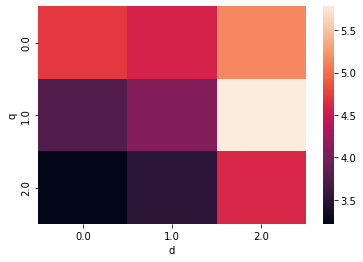

In [15]:
__ = df_result[['q','d','rmse']]
__ = __.groupby(['q','d'],as_index=False).mean()
_ = __.pivot('q','d','rmse')
sns.heatmap(_)

<AxesSubplot:xlabel='q', ylabel='p'>

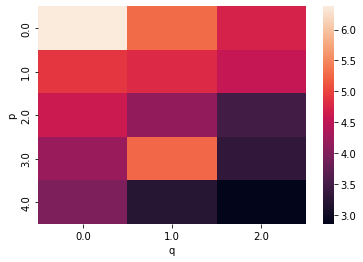

In [16]:
__ = df_result[['p','q','rmse']]
__ = __.groupby(['p','q'],as_index=False).mean()
_ = __.pivot('p','q','rmse')
sns.heatmap(_)

<AxesSubplot:xlabel='d', ylabel='p'>

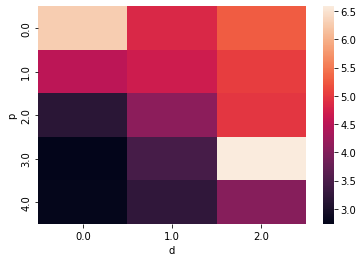

In [17]:
__ = df_result[['p','d','rmse']]
__ = __.groupby(['p','d'],as_index=False).mean()
_ = __.pivot('p','d','rmse')
sns.heatmap(_)